# 1. Setup

In [1]:
import sys
sys.path.append('../..')
from mobiquity.names import *

from io import BytesIO
from shutil import rmtree
from urllib.error import HTTPError

from bs4 import BeautifulSoup
import requests
from zipfile import ZipFile

# 2. LEHD data

In [2]:
states = pd.read_csv(DATA / 'us_states.csv').disp()

49 rows x 3 cols; Memory: 0.0 MiB


,name,code,fips
,<object>,<object>,<int64>
0,Alabama,AL,1


# 3. Collect AAA data
**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

## 3.1. Download

In [3]:
def download_aaa(handle, mode, year, states=states, overwrite=False):
    mode_ = ('drive' if mode == 'auto' else mode).lower()
    outpath = DATA / f'access/aaa/{mode_}_{year}.parquet'
    if (df := U.checkfile(outpath, overwrite)) is not None: return df
    st = states.set_index('name')
    root = 'https://conservancy.umn.edu'
    url = f'{root}/handle/11299/{handle}'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find('table', class_='table-striped')
    tags = [x for x in table.find_all('a') if x.text.endswith('.zip')]
    temp = U.mkdir(DATA / 'access/aaa/temp')
    res = []
    for tag in tqdm(tags):
        url = root + '/' + tag['href']
        label = url.split(handle + '/')[1].split('.')[0]
        state = label.split('_')[0].replace('%20', ' ')
        if state not in st.index: continue
        fips, code = st.loc[state]['fips'], st.loc[state]['code']
        with ZipFile(BytesIO(requests.get(url).content)) as z:
            for scale, label in D(County='county', Tract='census_tract',
                                  BG='block_group').items():
                file = f'{state}_{fips:02}_{mode}_{label}_{year}.csv'
                if code == 'DC': file = file.replace('of', 'Of')
                if file not in [x.filename for x in z.filelist]:
                    file = f'{state}_{mode}_{year}/{file}'
                z.extract(file, temp)
                df = pd.read_csv(temp / file).astype(D(geoid=str))
                df['thresh'] = (df.threshold / 60).astype(int).astype(str)
                df['access'] = df.weighted_average.astype(F32)
                df = df[['geoid', 'thresh', 'access']]
                df = df.assign(state=code, scale=scale, mode=mode_.title())
                res.append(df)
    df = pd.concat(res).reset_index(drop=1)
    cat_cols = 'state scale mode thresh geoid'.split()
    df = df.astype({x: CAT for x in cat_cols})[cat_cols + ['access']]
    df.to_parquet(U.mkfile(outpath))
    rmtree(temp)
    return df

dr21 = download_aaa('257163', 'auto', 2021, overwrite=0)#.disp() # 12s
tr21 = download_aaa('256251', 'transit', 2021, overwrite=0)#.disp(0) # 38s
bi21 = download_aaa('256167', 'bike', 2021, overwrite=0)#.disp(0) # 38s
aaa = (pd.concat([dr21, tr21, bi21])
       .astype(D(state=CAT, mode=CAT, geoid=CAT))).disp()

8,366,506 rows x 6 cols; Memory: 186.7 MiB


,state,scale,mode,thresh,geoid,access
,<category>,<category>,<category>,<category>,<category>,<float32>
0,CA,County,Drive,5,6001,17759.738281


# 4. Visualize

In [4]:
zonesIN = U.load(DATA / 'zones/zones_2010.parquet',
                 columns=['geoid', 'scale', 'county', 'geometry'],
                 filters=[('state', '==', 'IN')]).disp() # 10s

6,417 rows x 4 cols; Memory: 0.7 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,geometry
,<object>,<category>,<category>,<geometry>
0,18001,County,Adams,"POLYGON ((-9440153.084239 4962095.689279, -944..."


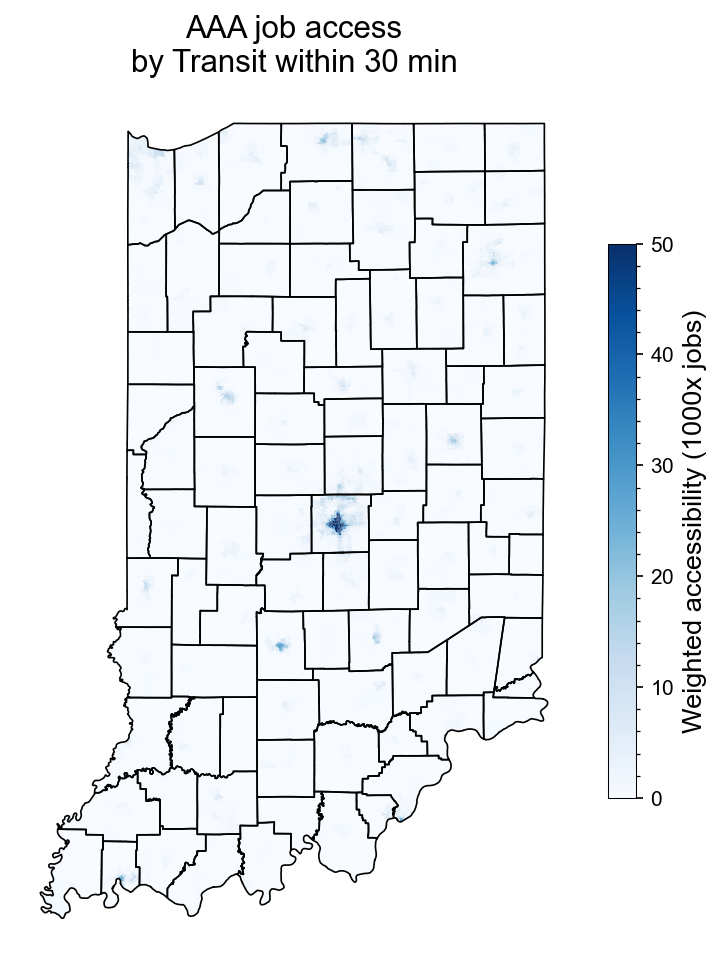

In [5]:
def plot_access(mode, thresh, xs=aaa, zones=zonesIN, counties=[],
                pctile=False, cmap='Blues', vmax=None, size=(6, 12), dpi=150):
    df = U.filt(xs, scale='BG', mode=mode, thresh=str(thresh))
    df = zones.merge(df).assign(access=lambda df: df.access / 1000)
    if isinstance(counties, list) and len(counties) > 0:
        df = df[df['county'].isin(counties)]
        zones = zones[zones['county'].isin(counties)]
    if pctile:
        df.access = df.access.rank(pct=True) * 100
    ax = U.plot(size=size, dpi=dpi, axoff=1,
               title=f'AAA job access\nby {mode} within {thresh} min')
    cbar_label = 'Weighted accessibility (1000x jobs)'
    df.plot(column='access', cmap=cmap, lw=0.2,
            legend=True, ax=ax, vmin=0, vmax=100 if pctile else vmax,
            legend_kwds=D(shrink=0.4, label=cbar_label))
    U.filt(zones, scale='County').plot(ax=ax, fc='none', ec='k', lw=0.8)

plot_access('Transit', 30, vmax=50)

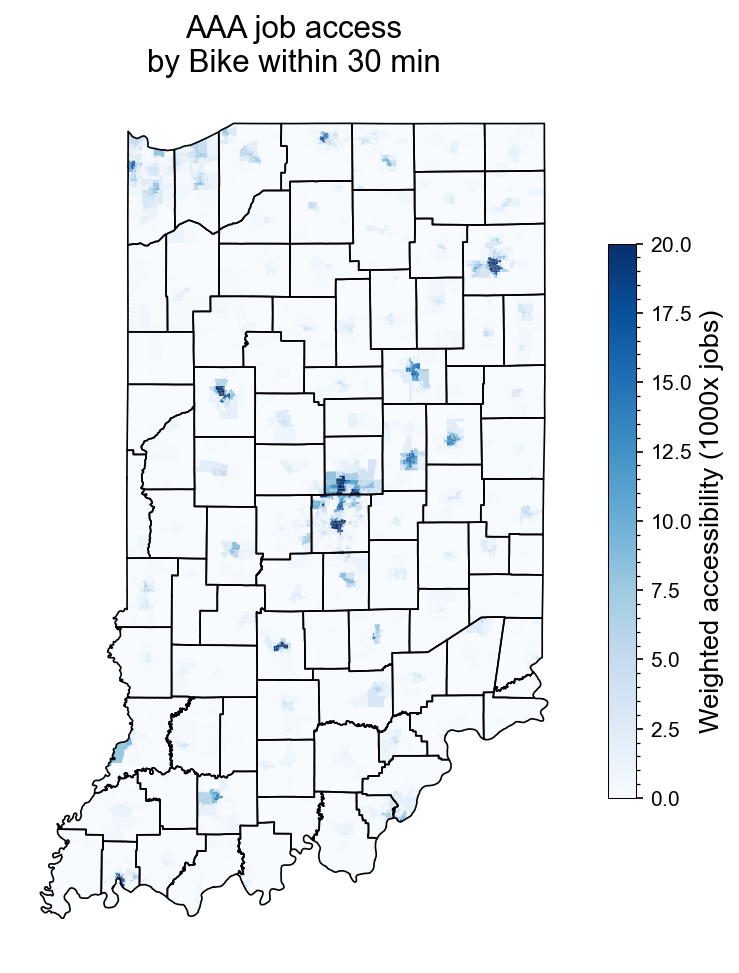

In [6]:
plot_access('Bike', 30, vmax=20)

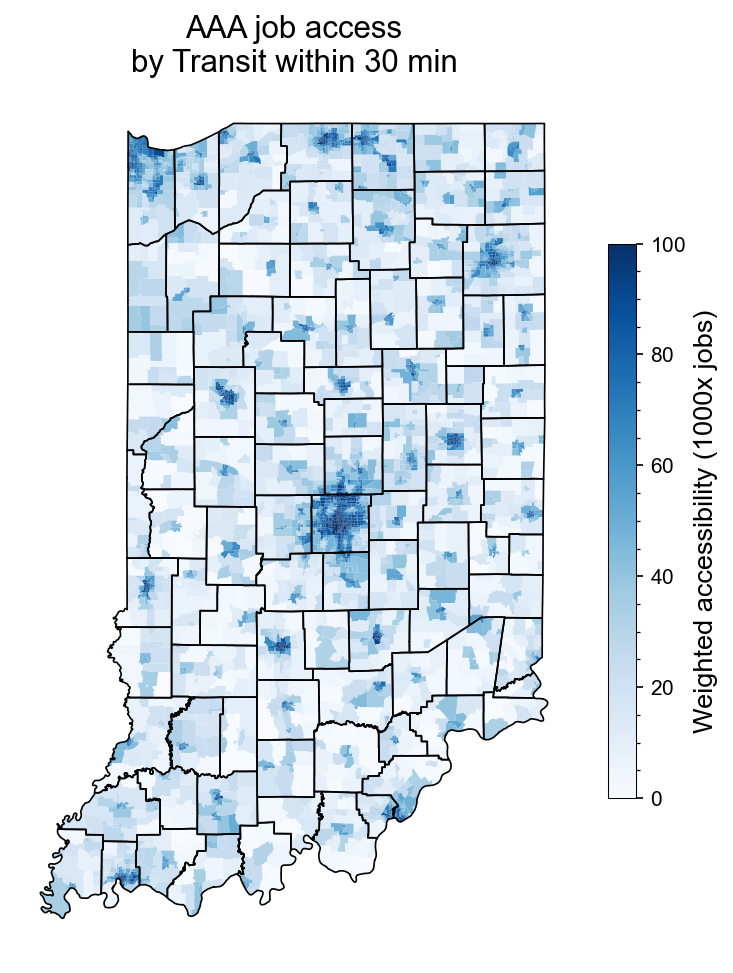

In [7]:
plot_access('Transit', 30, pctile=True)

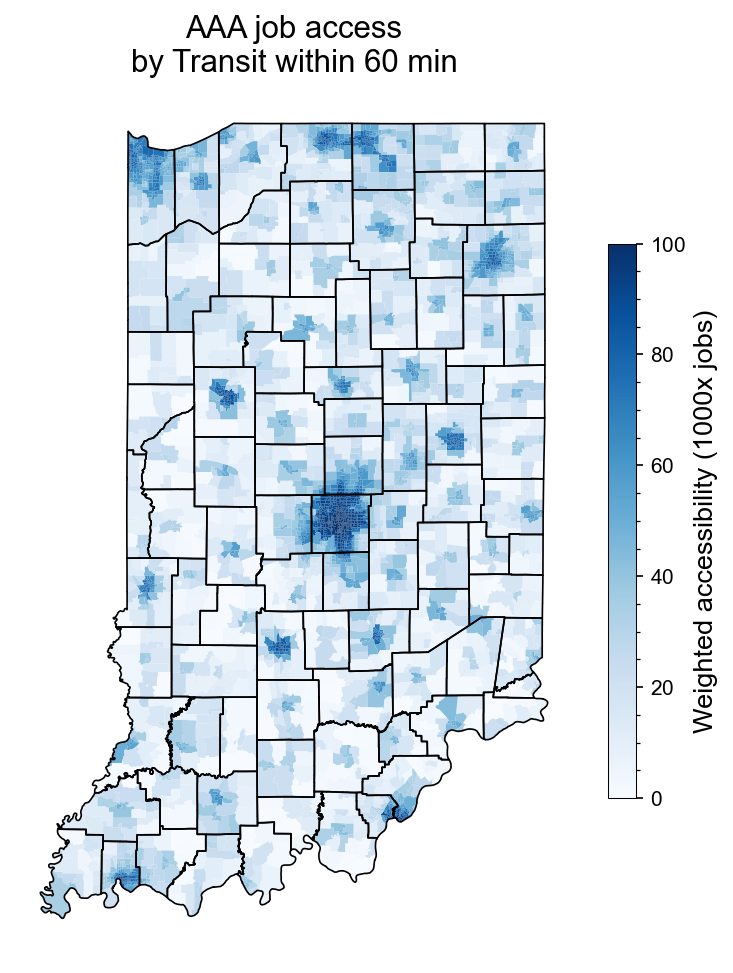

In [8]:
plot_access('Transit', 60, pctile=True)

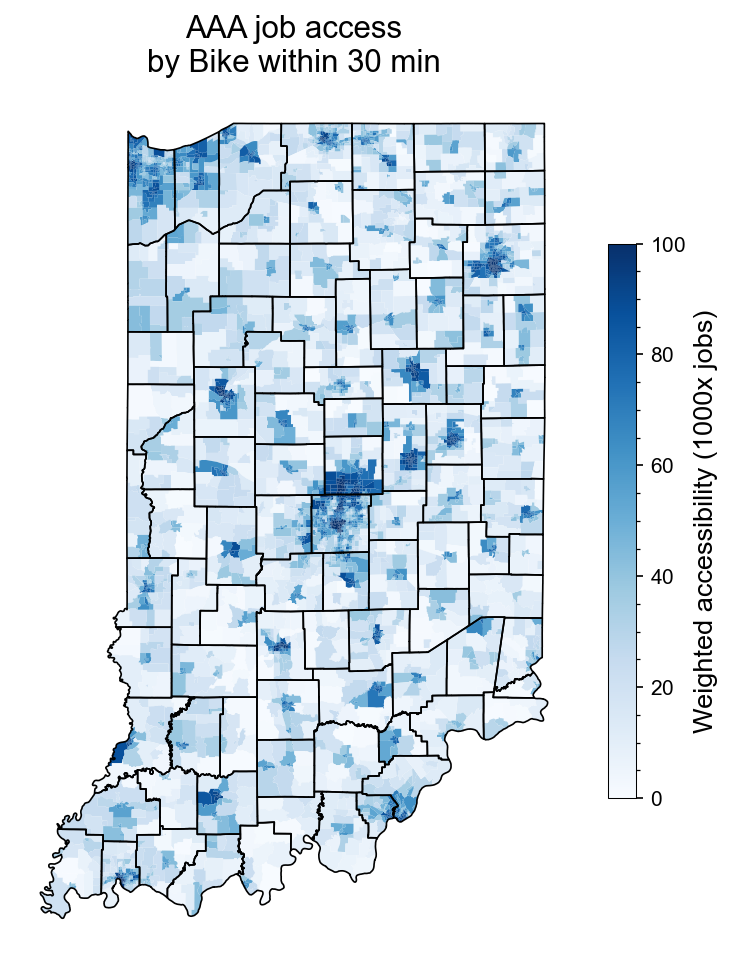

In [9]:
plot_access('Bike', 30, pctile=True)

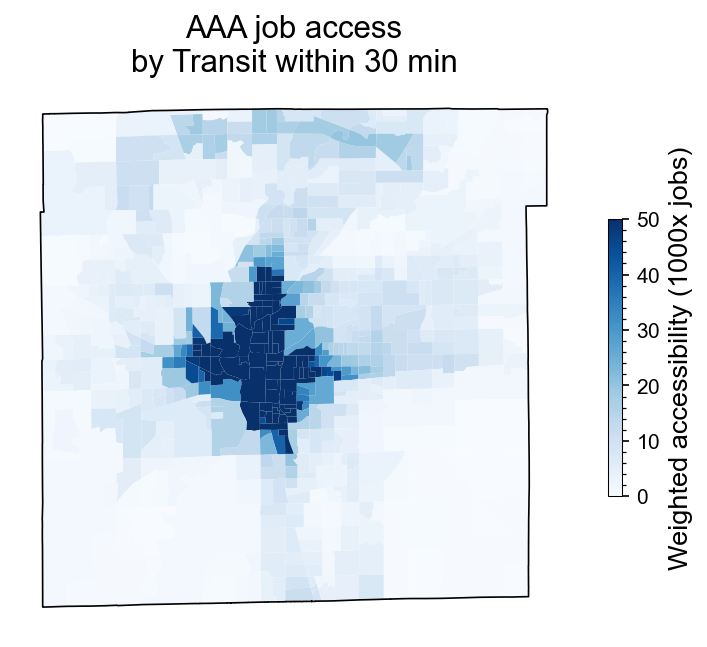

In [10]:
plot_access('Transit', 30, vmax=50, counties=['Marion'], size=(6, 6))

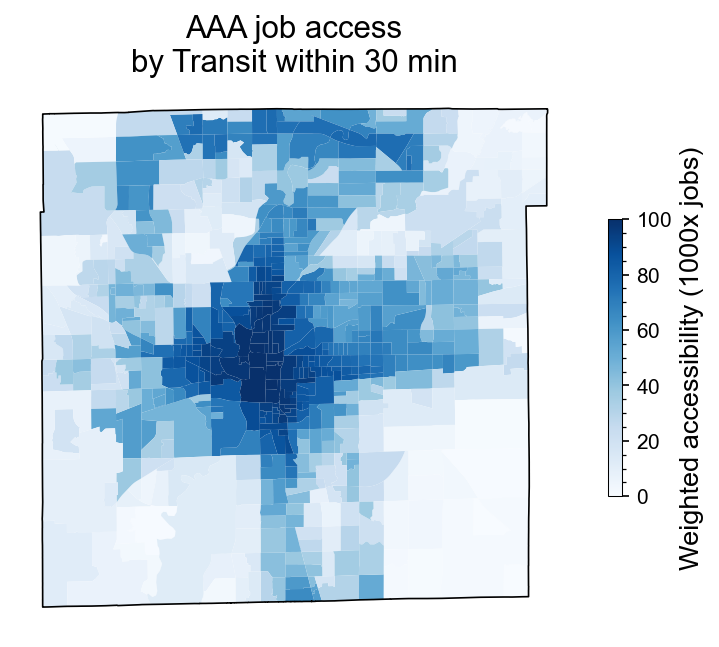

In [11]:
plot_access('Transit', 30, pctile=True, counties=['Marion'], size=(6, 6))

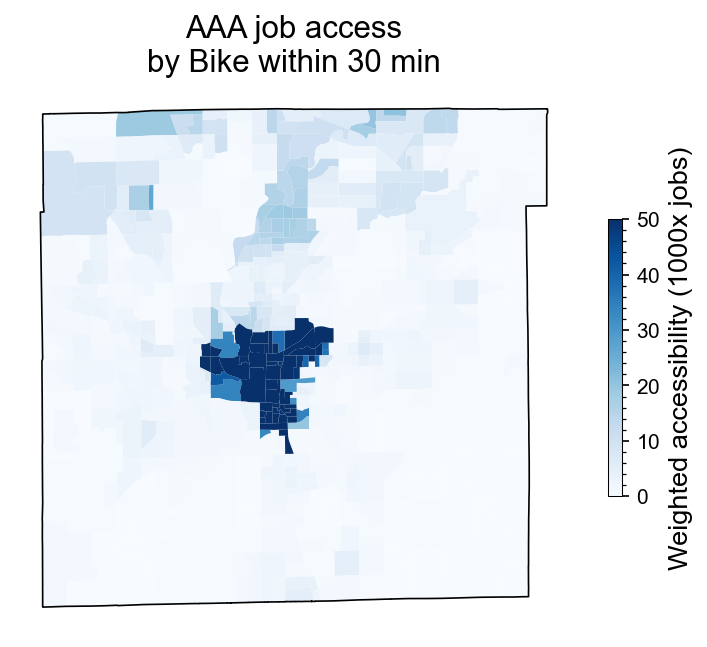

In [12]:
plot_access('Bike', 30, vmax=50, counties=['Marion'], size=(6, 6))

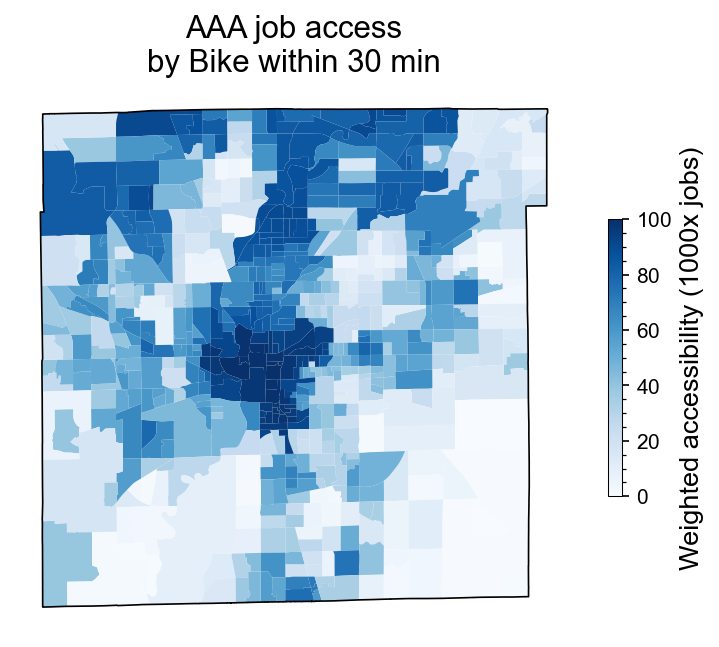

In [13]:
plot_access('Bike', 30, pctile=1, counties=['Marion'], size=(6, 6))